## 1.9. analysis of hashtag distribution

This notebook analyzes the distribution of the hashtags. The hashtags tag each cell so we know from which replicate and timepoint each of the cells come. This is allows us to get a good statistical significance on some of the downstream analyses. But first we have to make sure that the hashtags are equally distributed among the differen clusters. In the analysis below we visualize the abundance of each cell type for each hashtag. This figure is also part of supp. figure 1 in our manuscript.

In [1]:
### loading python libraries

# standard libraries
import numpy as np
import pandas as pd

# single cell libraries
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 0 

# plotting libraries
from matplotlib import pyplot as plt
from matplotlib import cm #for colormap
from matplotlib.colors import rgb2hex #for getting hex colors

# other 
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization
plt.rcParams['pdf.fonttype'] = 42 #for saving PDF with changeable text
plt.rcParams['ps.fonttype'] = 42 #for saving PDF with changeable text

### Load data

Here, we load the filtered HSPC dataset (as filtered in notebook 1.3).

In [2]:
### load Anndata object with the HSPC dataset (all four subsets incl.)
adata_path = "../data/count_matrices/all_filtered.h5ad"
adata = sc.read_h5ad(adata_path)

### Plot hashtags in UMAP
Here, we plot the hashtags in UMAPs.

In [3]:
### create colors
#cmap = cm.get_cmap('Set2', 9)
#colors = [rgb2hex(cmap(i)) for i in range(cmap.N)]
#colors = colors[0:4]
colors = ['#f0f0f0', '#D4D4D4','#7B7D7A', '#000000']
adata.uns["hashtags_colors"] = colors

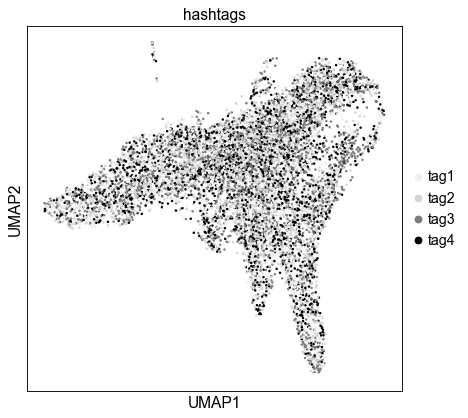

In [4]:
### plot all 4 timepoints in UMAP (coloured for hashtags)
sc.set_figure_params(figsize = (6,6))
sc.pl.umap(adata, color="hashtags", size=20)

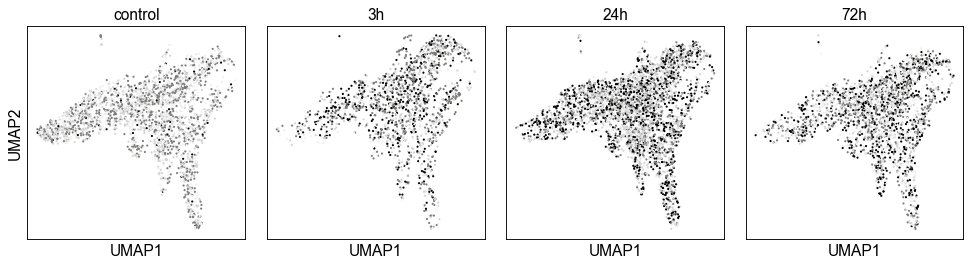

In [5]:
### plot each timepoint in individual umap (coloured for hashtags)
timepoints = adata.obs["time"].cat.categories

fig, axs = plt.subplots(1, len(timepoints), figsize=(15,3.5), gridspec_kw={'wspace':0.1, 'hspace':0.1})

for i in range(len(timepoints)):
    sc.pl.umap(adata[adata.obs["time"]==timepoints[i]], color="hashtags", ax=axs[i], show=False, size=15, title=timepoints[i])

for ax in axs.flat:
    ax.get_yaxis().set_visible(False)
    ax.get_legend().remove()

axs[0].get_yaxis().set_visible(True)

### Abundance hashtags per timepoint
Here, we plot the abundance of the hashtags in the four different timepoints.

In [6]:
### get abundance each hashtag per timepoint
timepoints = adata.obs['time'].cat.categories
hashtags = adata.obs['hashtags'].cat.categories

abund_per_timepoint = []

for time in timepoints:
    abund_tp = pd.DataFrame(adata[(adata.obs["time"]==time)].obs["hashtags"].value_counts())
    abund_tp = abund_tp.set_index(abund_tp.index.astype("str"))
    abund_per_timepoint.append(abund_tp)

abund_per_timepoint = pd.concat(abund_per_timepoint, axis=1)
abund_per_timepoint.columns = timepoints
abund_per_timepoint = abund_per_timepoint.loc[hashtags,:]
abund_per_timepoint = abund_per_timepoint.T

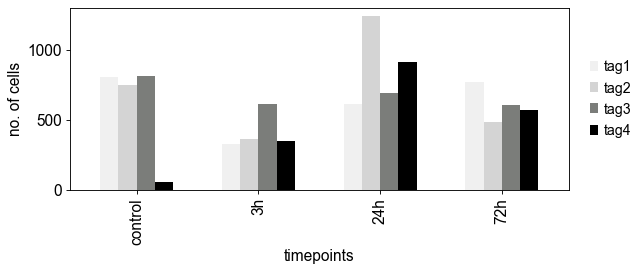

In [7]:
### plot abundances
fig, axs = plt.subplots(1, 1, figsize=(8,3))

abund_per_timepoint.plot(kind="bar", ax=axs, width=0.6, color=colors)
axs.grid(False)

# add legend and labels
axs.legend(loc="right", bbox_to_anchor=(1.15, 0.5), ncol=1, frameon=False)
axs.set_xlabel("timepoints")
axs.set_ylabel("no. of cells")

plt.show()

In [8]:
### get percentual abundances
perc_abund_per_timepoint = abund_per_timepoint.divide(abund_per_timepoint.sum(axis=1), axis=0)*100

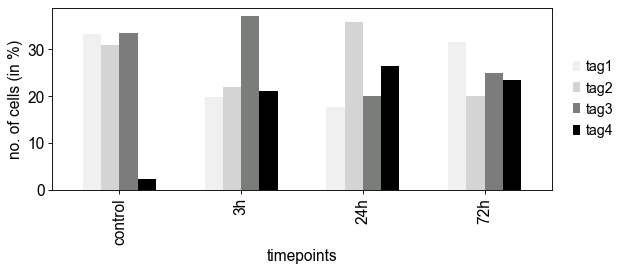

In [9]:
### plot percentual abundances
fig, axs = plt.subplots(1, 1, figsize=(8,3))

perc_abund_per_timepoint.plot(kind="bar", ax=axs, width=0.6, color=colors)
axs.grid(False)

# add legend and labels
axs.legend(loc="right", bbox_to_anchor=(1.15, 0.5), ncol=1, frameon=False)
axs.set_xlabel("timepoints")
axs.set_ylabel("no. of cells (in %)")

plt.show()

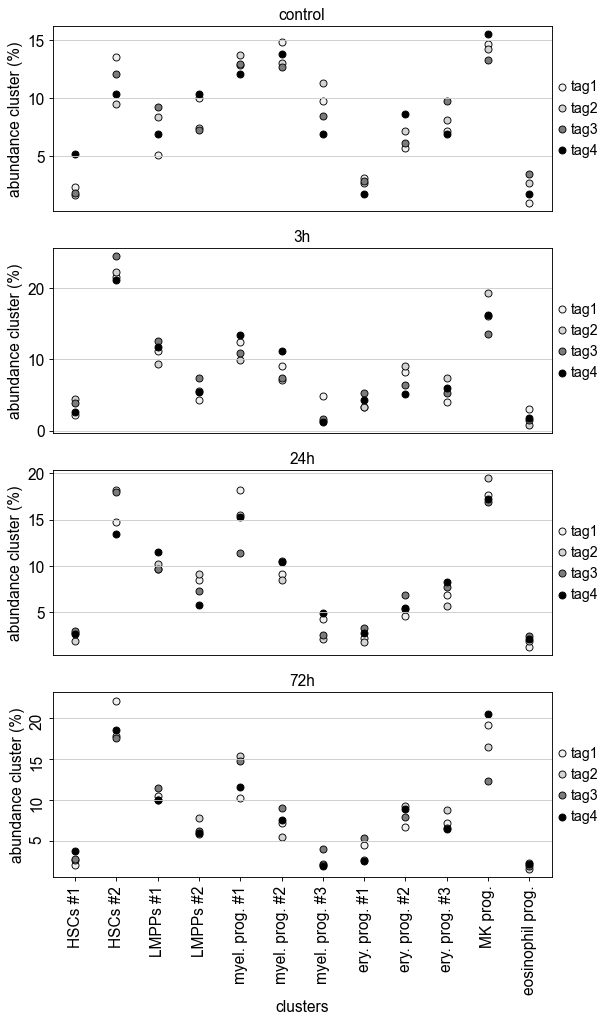

In [10]:
### plot abundances of cell types per hashtag
fig, axs = plt.subplots(4, 1, figsize=(8,14), gridspec_kw={'hspace':0.2})

for i, time in enumerate(timepoints):
    abund_per_tag = []

    for tag in hashtags:
        abund_tag = pd.DataFrame(adata[(adata.obs["hashtags"]==tag)&(adata.obs["time"]==time)].obs["clusters"].value_counts())
        abund_tag = abund_tag.set_index(abund_tag.index.astype("str"))
        abund_per_tag.append(abund_tag)

    abund_per_tag = pd.concat(abund_per_tag, axis=1)
    abund_per_tag.columns = hashtags
    total_cells = pd.DataFrame(abund_per_tag.sum()).transpose()
    abund_per_tag = abund_per_tag/total_cells.loc[0]*100
    abund_per_tag = abund_per_tag.fillna(0)
    abund_per_tag = abund_per_tag.loc[adata.obs['clusters'].cat.categories,]
    
    for idx, hashtag in enumerate(hashtags):
        axs[i].scatter(abund_per_tag.index.values, abund_per_tag[hashtag],
                       color=colors[idx], label=hashtag, edgecolors='black', linewidth=0.8, s=40)
        axs[i].legend(loc="right", bbox_to_anchor=(1.12, 0.5), ncol=1, frameon=False)

    axs[i].set_ylabel("abundance cluster (%)")
    axs[i].set_title(time)
    axs[i].get_xaxis().set_visible(False)

axs[i].tick_params(labelrotation=90)
axs[i].set_xlabel("clusters")
axs[i].get_xaxis().set_visible(True)
axs[i].xaxis.grid()

# save figure
save_path = "../figures/1.9.abundance_hashtags_per_cluster_per_timepoint.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)

plt.show()